# NR data eccentricities from Tamal's paper

In [40]:
import pylab
import h5py
import math
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform

from gw_eccentricity import load_waveform, load_data, get_available_methods, measure_eccentricity
from gw_eccentricity.load_data import get_available_waveform_origins, get_load_waveform_defaults, get_load_waveform_docs

from gw_eccentricity.plot_settings import use_fancy_plotsettings, labelsDict
from pycbc.waveform.waveform_modes import get_td_waveform_modes
from pycbc import types, fft, waveform
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib import ticker

import matplotlib.pyplot as plt
from IPython.display import HTML,display
import pandas as pd

In [41]:
NR = ['1355_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1356_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1357_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1358_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1359_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1360_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1361_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1362_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1363_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1365_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1366_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1367_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1368_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1369_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1370_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1371_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1372_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1373_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1374_rhOverM_Asymptotic_GeometricUnits_CoM.h5']
Ecc_ini = [0.127,0.163,0.222,0.226,0.227,0.302,0.305,0.372,0.376,0.108,0.145,0.218,0.220,0.222,0.367,0.367,0.133,0.212,0.214,0.359]

In [42]:
len(NR),len(Ecc_ini)

(20, 20)

In [43]:
origin = "SXSCatalog"
get_load_waveform_defaults(origin)

{'filepath': None,
 'metadata_path': None,
 'deltaTOverM': 0.1,
 'include_zero_ecc': False,
 'include_params_dict': False,
 'zero_ecc_approximant': 'IMRPhenomT',
 'num_orbits_to_remove_as_junk': 2,
 'mode_array': [(2, 2)],
 'extrap_order': 2}

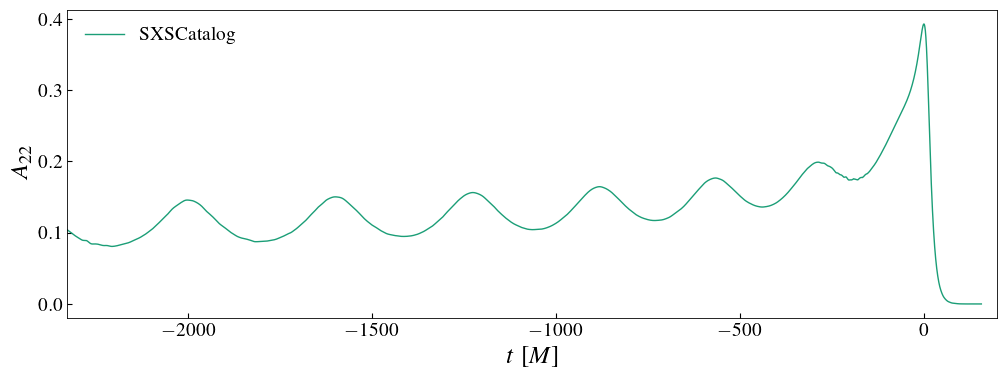

In [44]:
kwargs = {"filepath": "/home/pratul/Downloads/Project/NR_data/"+NR[6]}
dataDict = load_waveform(origin, **kwargs)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), label = origin)
ax.set_xlim(dataDict["t"][0], 200)
ax.set_xlabel(labelsDict["t_dimless"])
ax.set_ylabel(labelsDict["amp22"])
ax.legend(loc="upper left")

# Measure $e_0$ using "$Amplitude$" method

In [45]:
method = 'Amplitude'
return_dict = measure_eccentricity(tref_in=dataDict["t"], method = method, dataDict = dataDict)
eccentricity = return_dict["eccentricity"]
gwecc_object = return_dict["gwecc_object"]

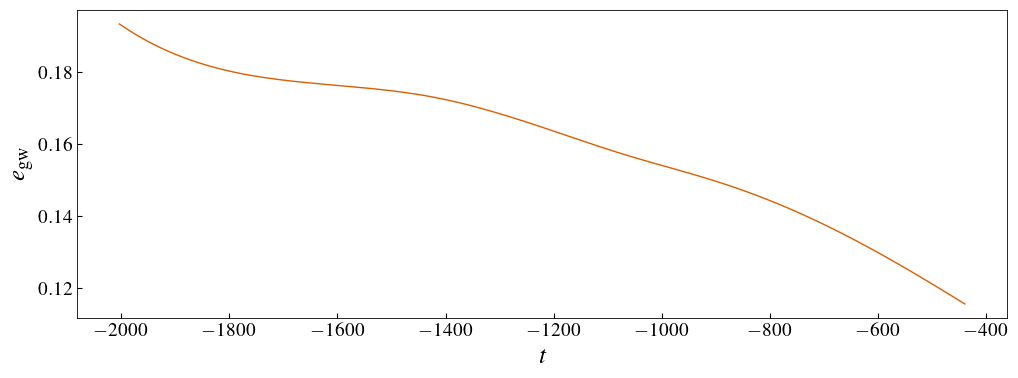

In [46]:
fig, ax = gwecc_object.plot_eccentricity()

In [47]:
ecc_new = []
def NR_Ecc(NR_data,method):
    kwargs = {"filepath": "/home/pratul/Downloads/Project/NR_data/"+NR[NR_data]}
    dataDict = load_waveform(origin, **kwargs)
    return_dict = measure_eccentricity(tref_in=dataDict["t"], method = method, dataDict = dataDict)
    eccentricity = return_dict["eccentricity"]
    return round(eccentricity[0],3)

In [48]:
method='Amplitude'
for i in range(0,len(NR)):
    ecc_new.append(NR_Ecc(i,method))

/home/pratul/anaconda3/envs/pycbc/lib/python3.7/site-packages/gw_eccentricity/eccDefinition.py:1319: UserWarning: egw(t) is nonmonotonic in the range [-2943.364986912851, -2942.364986912851]
For more verbose output use `debug_level=1`.
  point_to_verbose_output=True)
/home/pratul/anaconda3/envs/pycbc/lib/python3.7/site-packages/gw_eccentricity/eccDefinition.py:1319: UserWarning: egw(t) is nonmonotonic in the range [-3871.2331592158694, -2761.9331592159324]
For more verbose output use `debug_level=1`.
  point_to_verbose_output=True)


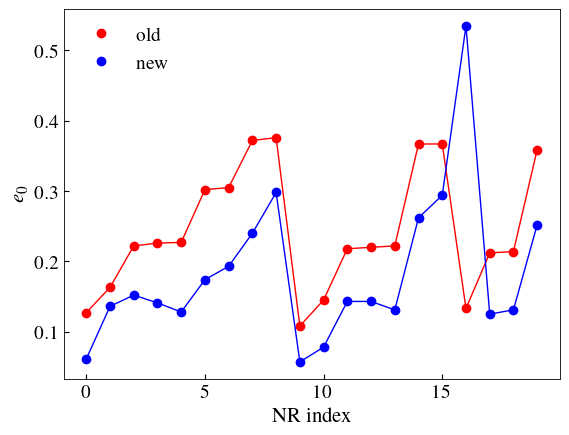

In [49]:
k=range(0,len(NR))
plt.plot(k,Ecc_ini,'ro',label='old')
plt.plot(k,ecc_new,'bo',label='new')
plt.plot(k,Ecc_ini,'r-',k,ecc_new,'b-')
plt.xlabel('NR index',size=15)
plt.ylabel('$e_0$',size=15)
plt.legend()

In [50]:
a=[]
for i in range(0,len(NR)):
    a.append(NR[i][0:4])   
a_list=[a,Ecc_ini,ecc_new]
df=pd.DataFrame(a_list,index = ["NR data", "Old $e_0$", "New $e_0$"])
display(HTML(df.to_html()))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
NR data,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371,1372,1373,1374
Old $e_0$,0.127,0.163,0.222,0.226,0.227,0.302,0.305,0.372,0.376,0.108,0.145,0.218,0.22,0.222,0.367,0.367,0.133,0.212,0.214,0.359
New $e_0$,0.061,0.136,0.152,0.141,0.128,0.174,0.193,0.24,0.298,0.057,0.078,0.143,0.143,0.131,0.262,0.294,0.535,0.125,0.131,0.252


# Interpolation

In [51]:
ecc_new = []
def NR_Ecc(NR_data,method):
    kwargs = {"filepath": "/home/pratul/Downloads/Project/NR_data/"+NR[NR_data]}
    dataDict = load_waveform(origin, **kwargs)
    return_dict = measure_eccentricity(tref_in=dataDict["t"], method = method, dataDict = dataDict)
    eccentricity = return_dict["eccentricity"]
    gwecc_object = return_dict["gwecc_object"]
    Time = return_dict["tref_out"]
    #print(len(Time),len(dataDict["t"]),len(eccentricity))
    intrp = interp1d(Time,eccentricity,kind='cubic',fill_value='extrapolate')
    return around(intrp(dataDict["t"][0]),3)

In [52]:
method='Amplitude'
for i in range(0,len(NR)):
    ecc_new.append(NR_Ecc(i,method))

/home/pratul/anaconda3/envs/pycbc/lib/python3.7/site-packages/gw_eccentricity/eccDefinition.py:1319: UserWarning: egw(t) is nonmonotonic in the range [-2943.364986912851, -2942.364986912851]
For more verbose output use `debug_level=1`.
  point_to_verbose_output=True)
/home/pratul/anaconda3/envs/pycbc/lib/python3.7/site-packages/gw_eccentricity/eccDefinition.py:1319: UserWarning: egw(t) is nonmonotonic in the range [-3871.2331592158694, -2761.9331592159324]
For more verbose output use `debug_level=1`.
  point_to_verbose_output=True)


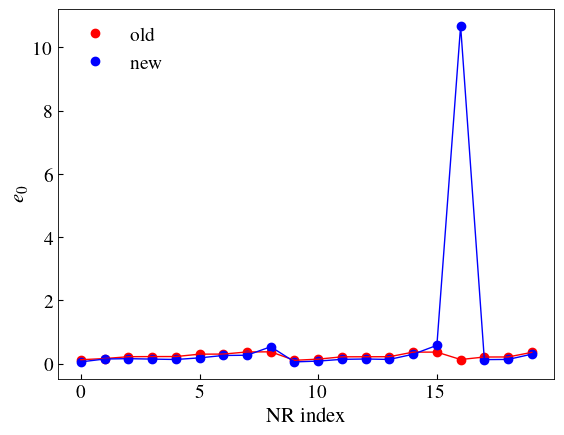

In [53]:
k=range(0,len(NR))
plt.plot(k,Ecc_ini,'ro',label='old')
plt.plot(k,ecc_new,'bo',label='new')
plt.plot(k,Ecc_ini,'r-',k,ecc_new,'b-')
plt.xlabel('NR index',size=15)
plt.ylabel('$e_0$',size=15)
plt.legend()

In [54]:
a=[]
for i in range(0,len(NR)):
    a.append(NR[i][0:4])   
a_list=[a,Ecc_ini,ecc_new]
df=pd.DataFrame(a_list,index = ["NR data", "Old $e_0$", "New $e_0$"])
display(HTML(df.to_html()))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
NR data,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371,1372,1373,1374
Old $e_0$,0.127,0.163,0.222,0.226,0.227,0.302,0.305,0.372,0.376,0.108,0.145,0.218,0.22,0.222,0.367,0.367,0.133,0.212,0.214,0.359
New $e_0$,0.058,0.149,0.16,0.146,0.134,0.185,0.261,0.268,0.537,0.058,0.083,0.139,0.149,0.136,0.3,0.581,10.679,0.13,0.136,0.302
